# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.transform import resize
from imageio import imread
import matplotlib.pyplot as plt
import datetime
import os
import math

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('D:/Master AI and ML/New Project/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('D:/Master AI and ML/New Project/Project_data/val.csv').readlines())
batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
x = 30
y = 120
z = 120
input_shape = (x,y,z,3)

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = math.floor(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_img = resize(image,(120,120))

                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_size_remain = len(folder_list) % batch_size
        batch += 1
        if (batch_size_remain!=0):
            batch_data = np.zeros((batch_size_remain,x,y,z,3))
            batch_labels = np.zeros((batch_size_remain,5))
            for folder in range(batch_size_remain):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resized_img = resize(image,(120,120))
                    
                    batch_data[folder,idx,:,:,0] = resized_img[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = resized_img[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = resized_img[:,:,2]/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = 'D:/Master AI and ML/New Project/Project_data/train'
val_path = 'D:/Master AI and ML/New Project/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### CNN2D + RNN Model

#### CNN2D + GRU

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(TimeDistributed(Conv2D(16,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(128,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(256,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(256,return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = optimizers.Adam(0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)   1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_initCNN2DGRU' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                verbose=1, callbacks=callbacks_list, validation_data=val_generator, 
                validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4474 - categorical_accuracy: 0.3952Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN2DGRU_2022-08-2400_24_46.361790\model-00001-1.44735-0.39517-1.90540-0.21000.h5
67/67 [==============================] - 181s 3s/step - loss: 1.4474 - categorical_accuracy: 0.3952 - val_loss: 1.9054 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8176 - categorical_accuracy: 0.7044
Epoch 2: saving model to model_initCNN2DGRU_2022-08-2400_24_46.361790\model-00002-0.81764-0.70437-2.37588-0.23000.h5
67/67 [==============================] - 177s 3s/step - loss: 0.8176 - categorical_accuracy: 0.7044 - val_loss: 2.3759 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/20
67/67 [============================


Epoch 20: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
67/67 [==============================] - 149s 2s/step - loss: 0.0484 - categorical_accuracy: 0.9985 - val_loss: 0.5869 - val_categorical_accuracy: 0.7900 - lr: 6.2500e-06


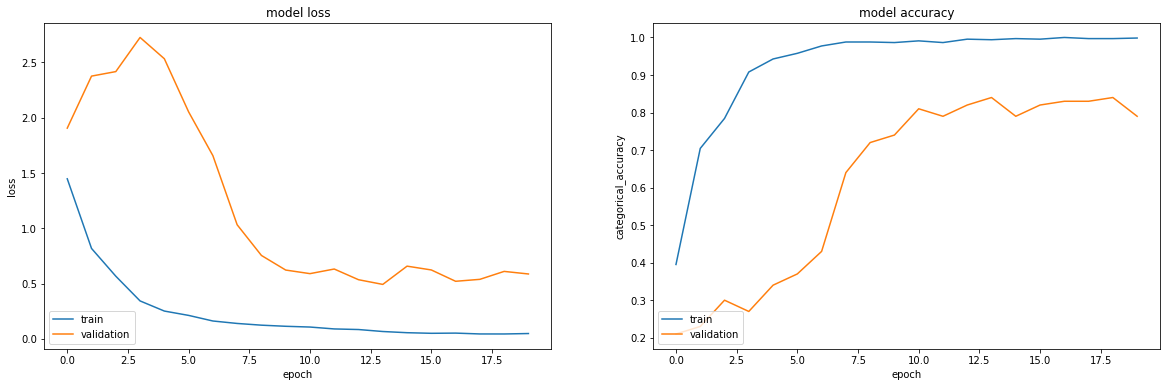

In [13]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model doesn't seem to be overfitting, it has good train accuracy and validation accuracy with least learning loss. Training the model with more epochs should probably improve the model to more extent.
- Training Accuracy: 99.70%
- Validation Accuracy: 84.00%

#### CNN2D + LSTM

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(TimeDistributed(Conv2D(16,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(128,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(256,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(256,return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [15]:
optimiser = optimizers.Adam(0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 60, 32)  

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_initCNN2DLSTM' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10


C:\Users\abhin\AppData\Local\Temp\ipykernel_2756\3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.4318 - categorical_accuracy: 0.3952Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN2DLSTM_2022-08-2400_24_46.361790\model-00001-1.43176-0.39517-1.62657-0.21000.h5
67/67 [==============================] - 153s 2s/step - loss: 1.4318 - categorical_accuracy: 0.3952 - val_loss: 1.6266 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0285 - categorical_accuracy: 0.6244
Epoch 2: saving model to model_initCNN2DLSTM_2022-08-2400_24_46.361790\model-00002-1.02847-0.62443-1.74236-0.20000.h5
67/67 [==============================] - 150s 2s/step - loss: 1.0285 - categorical_accuracy: 0.6244 - val_loss: 1.7424 - val_categorical_accuracy: 0.2000 - lr: 1.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7935 - categorical_accuracy: 0.7225
Epoch 3: saving model 

67/67 [==============================] - 149s 2s/step - loss: 0.0956 - categorical_accuracy: 0.9970 - val_loss: 0.5969 - val_categorical_accuracy: 0.8300 - lr: 6.2500e-06


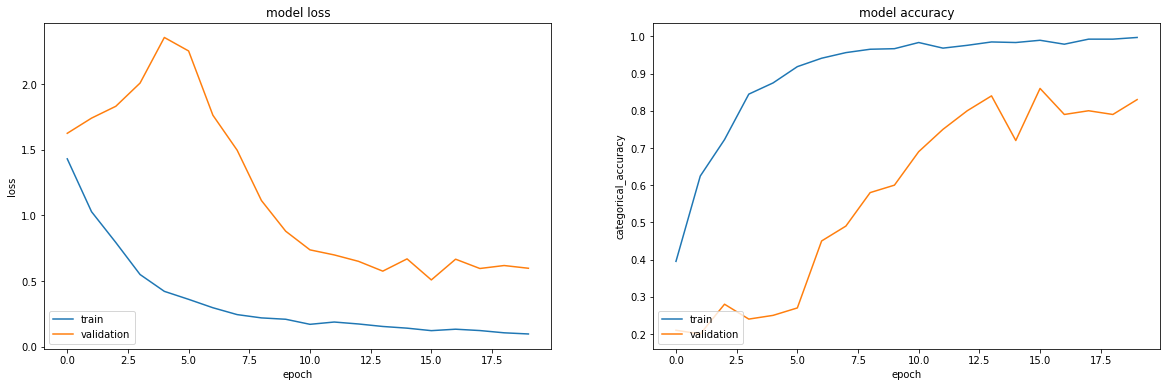

In [20]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model doesn't seem to be overfitting, it has good train accuracy and validation accuracy with least learning loss. Compared to the CNN2D + GRU the difference between the Training and Validation is reduced. Training the model with more epochs should probably improve the model to more extent.
- Training Accuracy: 98.94%
- Validation Accuracy: 86.00%

### CNN3D

In [21]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv3D(16,(3,3,3),padding = 'same',activation='relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(32,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(64,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(128,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(256,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [22]:
optimiser = optimizers.Adam(0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 batch_normalization_11 (Bat  (None, 15, 60, 60, 32)   128       
 chNormalization)                                                
                                                      

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [24]:
model_name = 'model_initCNN3D' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10


C:\Users\abhin\AppData\Local\Temp\ipykernel_2756\3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 1.7447 - categorical_accuracy: 0.3831Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN3D_2022-08-2400_24_46.361790\model-00001-1.74474-0.38311-2.11525-0.16000.h5
67/67 [==============================] - 152s 2s/step - loss: 1.7447 - categorical_accuracy: 0.3831 - val_loss: 2.1152 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9431 - categorical_accuracy: 0.6350
Epoch 2: saving model to model_initCNN3D_2022-08-2400_24_46.361790\model-00002-0.94311-0.63499-2.85316-0.17000.h5
67/67 [==============================] - 150s 2s/step - loss: 0.9431 - categorical_accuracy: 0.6350 - val_loss: 2.8532 - val_categorical_accuracy: 0.1700 - lr: 1.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7684 - categorical_accuracy: 0.7029
Epoch 3: saving model to model

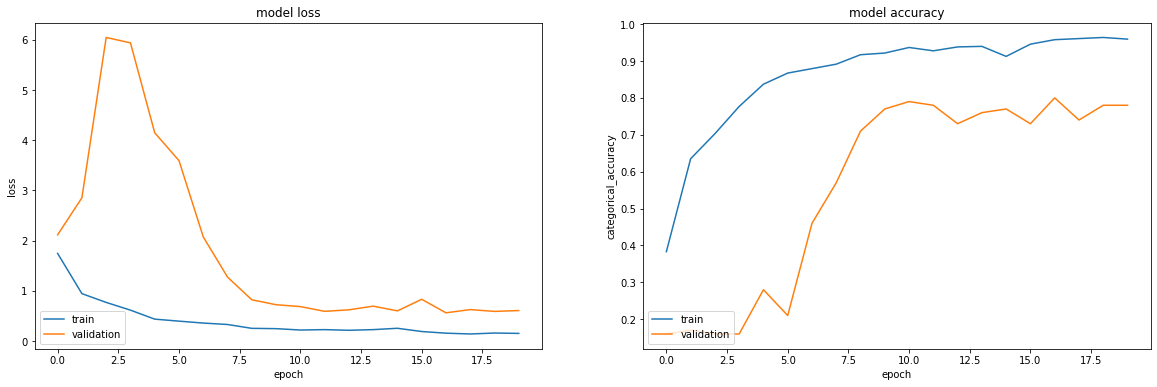

In [27]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model does seem to be overfitting, it has high difference of train accuracy and validation accuracy with a bit high learning loss. Adding of Regularizers and Removal of a layer should probably improve the model to some extent.
- Training Accuracy: 95.78%
- Validation Accuracy: 80.00%

### CNN3D + l2 Regularizers

In [28]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from keras.regularizers import l2

model = Sequential()

model.add(Conv3D(16,(3,3,3),padding = 'same',activation='relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(32,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(64,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Conv3D(128,(3,3,3),padding = 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D((2,2,2)))

model.add(Flatten())

model.add(Dense(256,activation='relu', kernel_regularizer = l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [29]:
optimiser = optimizers.Adam(0.0001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization_17 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                                 
 batch_normalization_18 (Bat  (None, 15, 60, 60, 32)   128       
 chNormalization)                                                
                                                      

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_name = 'model_initCNN3DL2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10


C:\Users\abhin\AppData\Local\Temp\ipykernel_2756\3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
67/67 [==============================] - ETA: 0s - loss: 6.4306 - categorical_accuracy: 0.4344Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN3DL2_2022-08-2400_24_46.361790\model-00001-6.43060-0.43439-7.61760-0.16000.h5
67/67 [==============================] - 171s 3s/step - loss: 6.4306 - categorical_accuracy: 0.4344 - val_loss: 7.6176 - val_categorical_accuracy: 0.1600 - lr: 1.0000e-04
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 5.7917 - categorical_accuracy: 0.6471
Epoch 2: saving model to model_initCNN3DL2_2022-08-2400_24_46.361790\model-00002-5.79175-0.64706-9.49781-0.14000.h5
67/67 [==============================] - 164s 2s/step - loss: 5.7917 - categorical_accuracy: 0.6471 - val_loss: 9.4978 - val_categorical_accuracy: 0.1400 - lr: 1.0000e-04
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 5.4690 - categorical_accuracy: 0.7014
Epoch 3: saving model to m

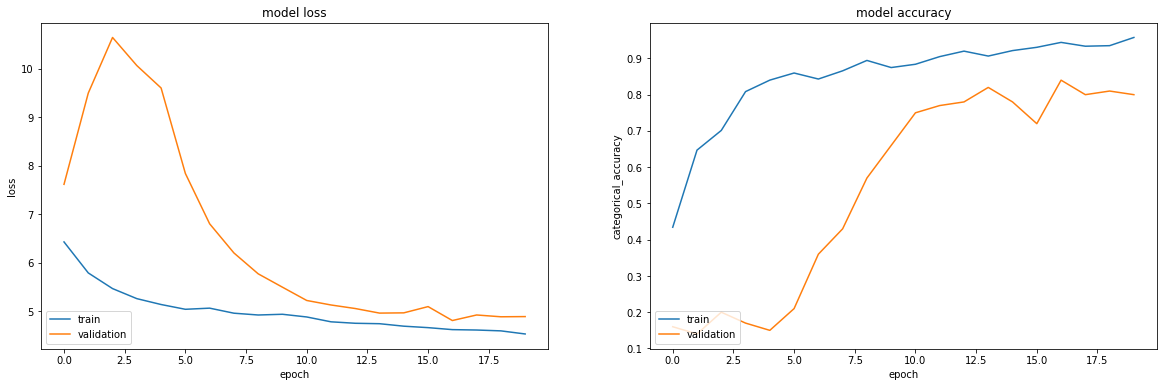

In [34]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model doesn't seem to be overfitting, it has good train accuracy and validation accuracy compared to CNN3D Model. But the training loss seems to have been increased rapidly to a greater extent of 4%.
- Training Accuracy: 90.65%
- Validation Accuracy: 82.00%

### CNN2D + LSTM (45 Epochs and SGD)

In [57]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(TimeDistributed(Conv2D(16,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(128,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(256,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(256,return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [58]:
optimiser = optimizers.SGD()
epochs = 45
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 30, 60, 60, 32)  

In [59]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [61]:
model_name = 'model_initCNN2DLSTM_2' + '_1' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

In [62]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [63]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\abhin\AppData\Local\Temp\ipykernel_2756\2003434324.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,


Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10
Epoch 1/45
67/67 [==============================] - ETA: 0s - loss: 1.3818 - categorical_accuracy: 0.4178Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00001-1.38177-0.41780-1.68832-0.21000.h5
67/67 [==============================] - 301s 5s/step - loss: 1.3818 - categorical_accuracy: 0.4178 - val_loss: 1.6883 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/45
67/67 [==============================] - ETA: 0s - loss: 1.0790 - categorical_accuracy: 0.5867
Epoch 2: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00002-1.07903-0.58673-2.10946-0.20000.h5
67/67 [==============================] - 146s 2s/step - loss: 1.0790 - categorical_accuracy: 0.5867 - val_loss: 2.1095 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/45
67/67 [============================

Epoch 21/45
67/67 [==============================] - ETA: 0s - loss: 0.1021 - categorical_accuracy: 0.9819
Epoch 21: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00021-0.10205-0.98190-0.49525-0.84000.h5
67/67 [==============================] - 149s 2s/step - loss: 0.1021 - categorical_accuracy: 0.9819 - val_loss: 0.4952 - val_categorical_accuracy: 0.8400 - lr: 0.0012
Epoch 22/45
67/67 [==============================] - ETA: 0s - loss: 0.0990 - categorical_accuracy: 0.9849
Epoch 22: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00022-0.09903-0.98492-0.93082-0.73000.h5
67/67 [==============================] - 175s 3s/step - loss: 0.0990 - categorical_accuracy: 0.9849 - val_loss: 0.9308 - val_categorical_accuracy: 0.7300 - lr: 0.0012
Epoch 23/45
67/67 [==============================] - ETA: 0s - loss: 0.0861 - categorical_accuracy: 0.9894
Epoch 23: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00023-0.08607-0.9894

67/67 [==============================] - ETA: 0s - loss: 0.0659 - categorical_accuracy: 0.9910
Epoch 40: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00040-0.06588-0.99095-0.53660-0.83000.h5

Epoch 40: ReduceLROnPlateau reducing learning rate to 4.882812390860636e-06.
67/67 [==============================] - 144s 2s/step - loss: 0.0659 - categorical_accuracy: 0.9910 - val_loss: 0.5366 - val_categorical_accuracy: 0.8300 - lr: 9.7656e-06
Epoch 41/45
67/67 [==============================] - ETA: 0s - loss: 0.0670 - categorical_accuracy: 0.9940
Epoch 41: saving model to model_initCNN2DLSTM_2_12022-08-2400_24_46.361790\model-00041-0.06700-0.99397-0.49166-0.84000.h5
67/67 [==============================] - 145s 2s/step - loss: 0.0670 - categorical_accuracy: 0.9940 - val_loss: 0.4917 - val_categorical_accuracy: 0.8400 - lr: 4.8828e-06
Epoch 42/45
67/67 [==============================] - ETA: 0s - loss: 0.0723 - categorical_accuracy: 0.9925
Epoch 42: saving model to m

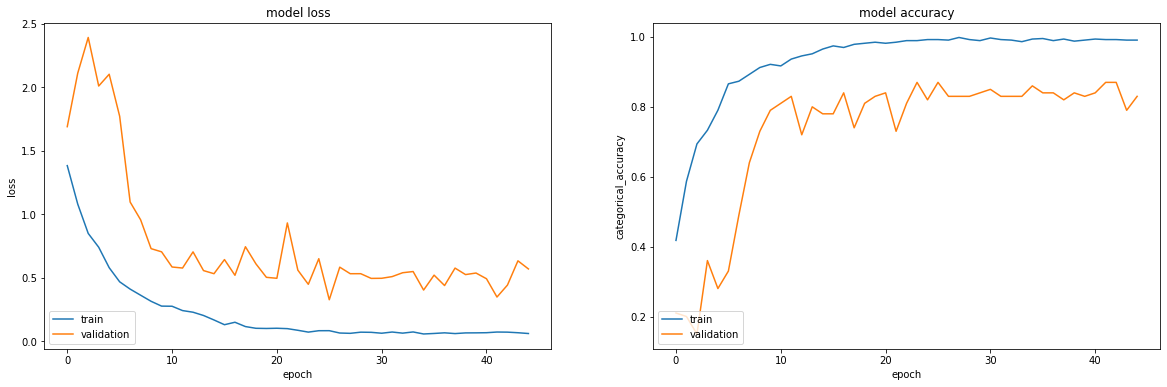

In [64]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model doesn't seem to be overfitting, it has good train accuracy and validation accuracy with improved training loss than the first CNN2D + LSTM Model. Training the model with more epochs and tuning the hyperparameter should probably improve the model to more extent.
- Training Accuracy: 99.40%
- Validation Accuracy: 88.00%

### CNN2D + LSTM (45 Epochs and Adam)

In [72]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(TimeDistributed(Conv2D(16,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(128,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(256,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))

model.add(LSTM(256,return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [73]:
optimiser = optimizers.Adam(0.0001)
epochs = 45
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_112 (TimeD  (None, 30, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_113 (TimeD  (None, 30, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_114 (TimeD  (None, 30, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_115 (TimeD  (None, 30, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_116 (TimeD  (None, 30, 60, 60, 32)  

In [74]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [75]:
model_name = 'model_initCNN2DLSTM_2' + '_2' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

In [76]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [77]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\abhin\AppData\Local\Temp\ipykernel_2756\2003434324.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,


Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10
Epoch 1/45
67/67 [==============================] - ETA: 0s - loss: 1.4826 - categorical_accuracy: 0.3590Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN2DLSTM_2_22022-08-2400_24_46.361790\model-00001-1.48262-0.35897-1.68171-0.21000.h5
67/67 [==============================] - 153s 2s/step - loss: 1.4826 - categorical_accuracy: 0.3590 - val_loss: 1.6817 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 2/45
67/67 [==============================] - ETA: 0s - loss: 1.0235 - categorical_accuracy: 0.6335
Epoch 2: saving model to model_initCNN2DLSTM_2_22022-08-2400_24_46.361790\model-00002-1.02350-0.63348-1.76146-0.21000.h5
67/67 [==============================] - 153s 2s/step - loss: 1.0235 - categorical_accuracy: 0.6335 - val_loss: 1.7615 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 3/45
67/67 [====================


Epoch 20: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
67/67 [==============================] - 149s 2s/step - loss: 0.0805 - categorical_accuracy: 0.9940 - val_loss: 0.6111 - val_categorical_accuracy: 0.7700 - lr: 6.2500e-06
Epoch 21/45
67/67 [==============================] - ETA: 0s - loss: 0.0732 - categorical_accuracy: 0.9955
Epoch 21: saving model to model_initCNN2DLSTM_2_22022-08-2400_24_46.361790\model-00021-0.07324-0.99548-0.63716-0.75000.h5
67/67 [==============================] - 156s 2s/step - loss: 0.0732 - categorical_accuracy: 0.9955 - val_loss: 0.6372 - val_categorical_accuracy: 0.7500 - lr: 3.1250e-06
Epoch 22/45
67/67 [==============================] - ETA: 0s - loss: 0.0647 - categorical_accuracy: 0.9985
Epoch 22: saving model to model_initCNN2DLSTM_2_22022-08-2400_24_46.361790\model-00022-0.06474-0.99849-0.63188-0.75000.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
67/67 [==============================] - 151s 

67/67 [==============================] - 146s 2s/step - loss: 0.0691 - categorical_accuracy: 0.9925 - val_loss: 0.6457 - val_categorical_accuracy: 0.7400 - lr: 1.2207e-08
Epoch 40/45
67/67 [==============================] - ETA: 0s - loss: 0.0650 - categorical_accuracy: 0.9970
Epoch 40: saving model to model_initCNN2DLSTM_2_22022-08-2400_24_46.361790\model-00040-0.06499-0.99698-0.59881-0.77000.h5

Epoch 40: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
67/67 [==============================] - 148s 2s/step - loss: 0.0650 - categorical_accuracy: 0.9970 - val_loss: 0.5988 - val_categorical_accuracy: 0.7700 - lr: 1.2207e-08
Epoch 41/45
67/67 [==============================] - ETA: 0s - loss: 0.0688 - categorical_accuracy: 1.0000
Epoch 41: saving model to model_initCNN2DLSTM_2_22022-08-2400_24_46.361790\model-00041-0.06876-1.00000-0.63939-0.74000.h5
67/67 [==============================] - 149s 2s/step - loss: 0.0688 - categorical_accuracy: 1.0000 - val_loss: 0.6394 - v

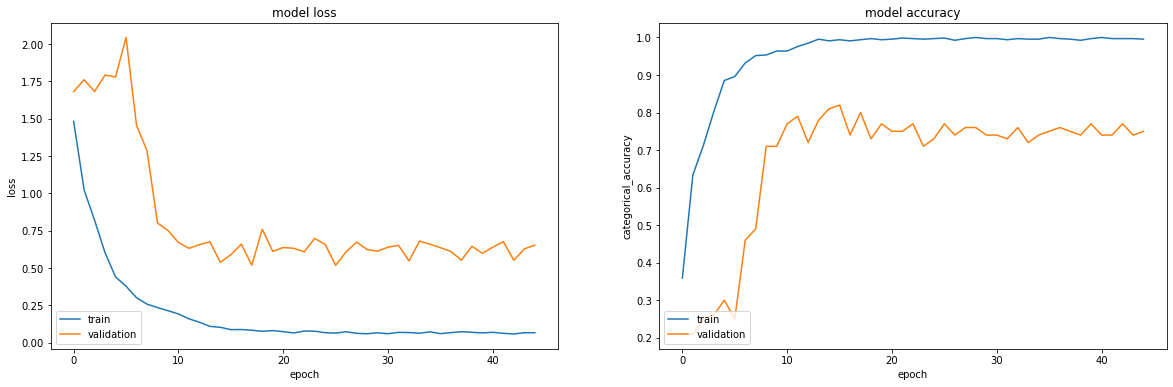

In [78]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### CNN2D + GRU (45 Epochs)

In [50]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, MaxPooling2D, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

model = Sequential()

model.add(TimeDistributed(Conv2D(16,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(32,(3,3),padding = 'same',activation='relu'),input_shape = input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(64,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(128,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Conv2D(256,(3,3),padding = 'same',activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))

model.add(TimeDistributed(Flatten()))

model.add(GRU(256,return_sequences = False))
model.add(Dropout(0.25))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

In [51]:
optimiser = optimizers.Adam(0.0001)
epochs = 45
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 60, 60, 32)  

In [52]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [53]:
model_name = 'model_initCNN2DLSTM_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,cooldown=1,verbose=1)
callbacks_list = [checkpoint, LR]

In [54]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [55]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\abhin\AppData\Local\Temp\ipykernel_2756\2003434324.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1,


Source path =  D:/Master AI and ML/New Project/Project_data/train ; batch size = 10
Epoch 1/45
67/67 [==============================] - ETA: 0s - loss: 1.4233 - categorical_accuracy: 0.4268Source path =  D:/Master AI and ML/New Project/Project_data/val ; batch size = 10

Epoch 1: saving model to model_initCNN2DLSTM_2_2022-08-2400_24_46.361790\model-00001-1.42326-0.42685-1.74765-0.18000.h5
67/67 [==============================] - 149s 2s/step - loss: 1.4233 - categorical_accuracy: 0.4268 - val_loss: 1.7477 - val_categorical_accuracy: 0.1800 - lr: 1.0000e-04
Epoch 2/45
67/67 [==============================] - ETA: 0s - loss: 0.8138 - categorical_accuracy: 0.7074
Epoch 2: saving model to model_initCNN2DLSTM_2_2022-08-2400_24_46.361790\model-00002-0.81375-0.70739-1.81911-0.21000.h5
67/67 [==============================] - 142s 2s/step - loss: 0.8138 - categorical_accuracy: 0.7074 - val_loss: 1.8191 - val_categorical_accuracy: 0.2100 - lr: 1.0000e-04
Epoch 3/45
67/67 [======================

67/67 [==============================] - 143s 2s/step - loss: 0.0181 - categorical_accuracy: 1.0000 - val_loss: 0.6581 - val_categorical_accuracy: 0.7900 - lr: 6.2500e-06
Epoch 21/45
67/67 [==============================] - ETA: 0s - loss: 0.0184 - categorical_accuracy: 1.0000
Epoch 21: saving model to model_initCNN2DLSTM_2_2022-08-2400_24_46.361790\model-00021-0.01844-1.00000-0.58292-0.82000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
67/67 [==============================] - 146s 2s/step - loss: 0.0184 - categorical_accuracy: 1.0000 - val_loss: 0.5829 - val_categorical_accuracy: 0.8200 - lr: 6.2500e-06
Epoch 22/45
67/67 [==============================] - ETA: 0s - loss: 0.0205 - categorical_accuracy: 1.0000
Epoch 22: saving model to model_initCNN2DLSTM_2_2022-08-2400_24_46.361790\model-00022-0.02051-1.00000-0.66519-0.79000.h5
67/67 [==============================] - 146s 2s/step - loss: 0.0205 - categorical_accuracy: 1.0000 - val_loss: 0.6652 - val_


Epoch 39: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
67/67 [==============================] - 144s 2s/step - loss: 0.0198 - categorical_accuracy: 1.0000 - val_loss: 0.6072 - val_categorical_accuracy: 0.8100 - lr: 1.2207e-08
Epoch 40/45
67/67 [==============================] - ETA: 0s - loss: 0.0191 - categorical_accuracy: 1.0000
Epoch 40: saving model to model_initCNN2DLSTM_2_2022-08-2400_24_46.361790\model-00040-0.01911-1.00000-0.58542-0.82000.h5
67/67 [==============================] - 146s 2s/step - loss: 0.0191 - categorical_accuracy: 1.0000 - val_loss: 0.5854 - val_categorical_accuracy: 0.8200 - lr: 6.1035e-09
Epoch 41/45
67/67 [==============================] - ETA: 0s - loss: 0.0236 - categorical_accuracy: 0.9985
Epoch 41: saving model to model_initCNN2DLSTM_2_2022-08-2400_24_46.361790\model-00041-0.02363-0.99849-0.58245-0.82000.h5

Epoch 41: ReduceLROnPlateau reducing learning rate to 3.051757735406113e-09.
67/67 [==============================] - 144s 

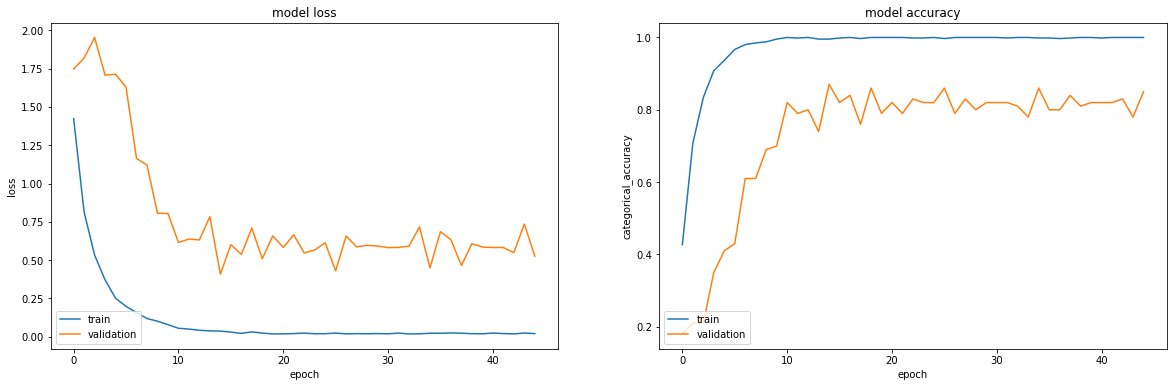

In [56]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

The model doesn't seem to be overfitting, it has good train accuracy and validation accuracy with improved training loss than the first CNN2D + GRU Model. But there is not much significant improvement in the model even after training it for more epochs.
- Training Accuracy: 99.85%
- Validation Accuracy: 86.00%

# Conclusion

### After trying out multiple models, CNN2D + LSTM (45 Epochs) seems to be a better model in terms of Accuracy of Training and Validation and has comparitively less Training Loss. The selected checkpoint .h5 has been attached with the same.